<a href="https://colab.research.google.com/github/mingyung-park/AIFFEL_quest_rs/blob/main/GoingDeeper/Deeper02/augmentationAblationstudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

In [46]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:80%]','train[80%:]', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# Augmentation Function

Mixup, Cutmix function

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

preprocess & aug function

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(
    ds, is_test=False,
    batch_size=16,
    with_aug=False,
    with_cutmix=False,
    with_mixup=False
):

    #기본 전처리
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )

    # Augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )

    # Batch
    ds = ds.batch(batch_size)

    # CutMix, MixUp, 또는 OneHot 중 하나만 적용
    if not is_test:
        if with_cutmix:
            ds = ds.map(cutmix, num_parallel_calls=2)
        elif with_mixup:
            ds = ds.map(mixup, num_parallel_calls=2)
        else:
            ds = ds.map(onehot, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# Model

build model function

In [ ]:
num_classes = ds_info.features["label"].num_classes

def build_resnet50_model(name, input_shape=(224, 224, 3), num_classes=120):
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    model = keras.models.Sequential([
        base_model,
        keras.layers.Dense(num_classes, activation='softmax')
    ], name=name)
    return model

##  train

ready for train

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/AIFFEL/DeepDive'

EPOCH = 30

In [ ]:
import pandas as pd

def save_history_to_csv(history, filename="history.csv"):
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(filename, index=False)

# 체크포인트 콜백 생성
def get_checkpoint_cb(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{model_name}_best.weights.h5",
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

#모델 생성, 데이터 전처리, 컴파일, 학습
def train_resnet_model(
    model_name,
    ds_train,
    ds_val,
    with_aug=False,
    with_mixup=False,
    with_cutmix=False,
    epochs=25,
    batch_size=16,
    num_classes=120
):
    # 모델 정의
    model = build_resnet50_model(model_name, num_classes=num_classes)

    # 체크포인트 콜백
    checkpoint_cb = get_checkpoint_cb(model_name)

    ds_train_proc = apply_normalize_on_dataset(
        ds_train, with_aug=with_aug, with_mixup=with_mixup, batch_size=batch_size
    )
    ds_val_proc = apply_normalize_on_dataset(
        ds_val, is_test=True, batch_size=batch_size
    )

    # 컴파일
    model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
            metrics=[
                'accuracy',
                keras.metrics.F1Score(average="micro", name="f1_score")
            ]
        )

    # 훈련
    history = model.fit(
        ds_train_proc,
        steps_per_epoch=int(ds_info.splits['train'].num_examples*0.8/ batch_size),
        validation_steps=int((ds_info.splits['train'].num_examples*0.2) / batch_size),
        validation_data=ds_val_proc,
        epochs=epochs,
        callbacks=[checkpoint_cb],
        verbose=1
    )

    # 히스토리 저장
    save_history_to_csv(history, f"{model_name}_history.csv")

    # 베스트모델 로드
    model.load_weights(f"{model_name}_best.weights.h5")

    return model, history


baseline model

In [ ]:
model_base_resnet50, history_base_resnet50 = train_resnet_model(
    model_name="base_resnet50",
    ds_train=ds_train,
    ds_val=ds_val,
    with_aug=False,
    with_mixup=False,
    with_cutmix=False,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

Epoch 1/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2488 - f1_score: 0.2488 - loss: 3.3955
Epoch 1: val_loss improved from inf to 4.67387, saving model to base_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.2493 - f1_score: 0.2493 - loss: 3.3921 - val_accuracy: 0.0342 - val_f1_score: 0.0342 - val_loss: 4.6739
Epoch 2/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7445 - f1_score: 0.7445 - loss: 0.9625
Epoch 2: val_loss improved from 4.67387 to 1.48738, saving model to base_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7447 - f1_score: 0.7447 - loss: 0.9619 - val_accuracy: 0.5625 - val_f1_score: 0.5625 - val_loss: 1.4874
Epoch 3/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9163 - f1_score: 0.9163 - loss: 0.3717
Epoch 3: val_loss improved from 1.48738 to 1.12841, saving model to base_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9164 - f1_sco

base aug model

In [ ]:
model_base_aug_resnet50, history_base_aug_resnet50 = train_resnet_model(
    model_name="base_aug_resnet50",
    ds_train=ds_train,
    ds_val=ds_val,
    with_aug=True,
    with_mixup=False,
    with_cutmix=False,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

Epoch 1/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2324 - f1_score: 0.2324 - loss: 3.4471
Epoch 1: val_loss improved from inf to 4.55265, saving model to base_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.2330 - f1_score: 0.2330 - loss: 3.4438 - val_accuracy: 0.0571 - val_f1_score: 0.0571 - val_loss: 4.5526
Epoch 2/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6666 - f1_score: 0.6666 - loss: 1.1977
Epoch 2: val_loss improved from 4.55265 to 1.40967, saving model to base_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.6667 - f1_score: 0.6667 - loss: 1.1973 - val_accuracy: 0.5858 - val_f1_score: 0.5858 - val_loss: 1.4097
Epoch 3/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8181 - f1_score: 0.8181 - loss: 0.6772
Epoch 3: val_loss improved from 1.40967 to 1.26491, saving model to base_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8

Cutmix aug model

In [ ]:
model_cutmix_aug_resnet50, history_cutmix_aug_resnet50 = train_resnet_model(
    model_name="cutmix_aug_resnet50",
    ds_train=ds_train,
    ds_val=ds_val,
    with_aug=False,
    with_mixup=False,
    with_cutmix=True,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

Epoch 1/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2473 - f1_score: 0.2473 - loss: 3.3988
Epoch 1: val_loss improved from inf to 4.81438, saving model to cutmix_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.2478 - f1_score: 0.2478 - loss: 3.3954 - val_accuracy: 0.0188 - val_f1_score: 0.0187 - val_loss: 4.8144
Epoch 2/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7124 - f1_score: 0.7124 - loss: 1.0440
Epoch 2: val_loss improved from 4.81438 to 1.24767, saving model to cutmix_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7126 - f1_score: 0.7126 - loss: 1.0434 - val_accuracy: 0.6371 - val_f1_score: 0.6371 - val_loss: 1.2477
Epoch 3/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9004 - f1_score: 0.9004 - loss: 0.4161
Epoch 3: val_loss improved from 1.24767 to 1.09221, saving model to cutmix_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accurac

mixup aug model

In [ ]:
model_mixup_aug_resnet50, history_mixup_aug_resnet50 = train_resnet_model(
    model_name="mixup_aug_resnet50",
    ds_val=ds_val,
    ds_train=ds_train,
    with_aug=False,
    with_mixup=True,
    with_cutmix=False,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

Epoch 1/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1111 - f1_score: 0.0941 - loss: 4.3802
Epoch 1: val_loss improved from inf to 5.40546, saving model to mixup_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.1115 - f1_score: 0.0944 - loss: 4.3784 - val_accuracy: 0.0146 - val_f1_score: 0.0146 - val_loss: 5.4055
Epoch 2/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4124 - f1_score: 0.3424 - loss: 3.0623
Epoch 2: val_loss improved from 5.40546 to 1.95294, saving model to mixup_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4126 - f1_score: 0.3425 - loss: 3.0619 - val_accuracy: 0.4708 - val_f1_score: 0.4708 - val_loss: 1.9529
Epoch 3/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5493 - f1_score: 0.4566 - loss: 2.6917
Epoch 3: val_loss improved from 1.95294 to 1.60852, saving model to mixup_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 

base+mixup model

In [ ]:
model_baseaug_mixup_resnet50, history_baseaug_mixup_resnet50 = train_resnet_model(
    model_name="baseaug_mixup_resnet50",
    ds_val=ds_val,
    ds_train=ds_train,
    with_aug=True,
    with_mixup=True,
    with_cutmix=False,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

Epoch 1/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1054 - f1_score: 0.0895 - loss: 4.4403
Epoch 1: val_loss improved from inf to 4.84588, saving model to baseaug_mixup_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.1057 - f1_score: 0.0898 - loss: 4.4385 - val_accuracy: 0.0258 - val_f1_score: 0.0258 - val_loss: 4.8459
Epoch 2/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3909 - f1_score: 0.3279 - loss: 3.1301
Epoch 2: val_loss improved from 4.84588 to 1.63736, saving model to baseaug_mixup_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.3910 - f1_score: 0.3280 - loss: 3.1297 - val_accuracy: 0.5592 - val_f1_score: 0.5592 - val_loss: 1.6374
Epoch 3/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4930 - f1_score: 0.4116 - loss: 2.8390
Epoch 3: val_loss did not improve from 1.63736
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.4931 - f1_score: 0.4116 - loss: 2.8387 - val_a

base+cutmix model

In [ ]:
model_baseaug_cutmix_resnet50, history_baseaug_cutmix_resnet50 = train_resnet_model(
    model_name="baseaug_cutmix_resnet50",
    ds_val=ds_val,
    ds_train=ds_train,
    with_aug=True,
    with_mixup=False,
    with_cutmix=True,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

Epoch 1/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2372 - f1_score: 0.2372 - loss: 3.4424
Epoch 1: val_loss improved from inf to 4.46631, saving model to baseaug_cutmix_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.2377 - f1_score: 0.2377 - loss: 3.4392 - val_accuracy: 0.0671 - val_f1_score: 0.0671 - val_loss: 4.4663
Epoch 2/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6791 - f1_score: 0.6791 - loss: 1.1633
Epoch 2: val_loss improved from 4.46631 to 1.28045, saving model to baseaug_cutmix_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6792 - f1_score: 0.6792 - loss: 1.1628 - val_accuracy: 0.6308 - val_f1_score: 0.6308 - val_loss: 1.2804
Epoch 3/30
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8028 - f1_score: 0.8028 - loss: 0.7058
Epoch 3: val_loss did not improve from 1.28045
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8029 - f1_score: 0.8029 - loss: 0.7055 - val

# Plot History

plot & summarize function

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history_list, model_list):
    metrics = ['accuracy', 'val_accuracy', 'f1_score', 'val_f1_score', 'loss', 'val_loss']
    titles = {
        'accuracy': 'Train Accuracy',
        'val_accuracy': 'Validation Accuracy',
        'f1_score': 'Train F1 Score',
        'val_f1_score': 'Validation F1 Score',
        'loss': 'Train Loss',
        'val_loss': 'Validation Loss'
    }

    n_rows, n_cols = 3, 2
    plt.figure(figsize=(18, 10))

    for idx, metric in enumerate(metrics):
        plt.subplot(n_rows, n_cols, idx + 1)
        for history, model_name in zip(history_list, model_list):
            if metric in history.history:
                plt.plot(history.history[metric], label=model_name)
        plt.title(titles[metric])
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def summarize_bestmodel_metrics(history_list, modelname_lis):
    summary = {
        "Model": [],
        "Best Epoch (Val Loss)": [],
        "Val Accuracy": [],
        "Val F1 Score": [],
        "Val Loss": [],
    }

    for model_name, history in zip(modelname_list, history_list):
        hist = history.history
        val_acc = hist.get("val_accuracy", [])
        val_f1 = hist.get("val_f1_score", [])
        val_loss = hist.get("val_loss", [])

        if val_loss:
            best_epoch = int(np.argmin(val_loss))
            summary["Model"].append(model_name)
            summary["Best Epoch (Val Loss)"].append(best_epoch + 1)  # 1에폭부터 시작
            summary["Val Accuracy"].append(f"{val_acc[best_epoch]:.4f}" if val_acc else "-")
            summary["Val F1 Score"].append(f"{val_f1[best_epoch]:.4f}" if val_f1 else "-")
            summary["Val Loss"].append(f"{val_loss[best_epoch]:.4f}")
        else:
            summary["Model"].append(model_name)
            summary["Best Epoch (Val Loss)"].append("-")
            summary["Val Accuracy"].append("-")
            summary["Val F1 Score"].append("-")
            summary["Val Loss"].append("-")

    return pd.DataFrame(summary)

In [ ]:
history_list=[
    history_base_resnet50,
    history_base_aug_resnet50,
    history_cutmix_aug_resnet50,
    history_mixup_aug_resnet50,
    history_baseaug_mixup_resnet50,
    history_baseaug_cutmix_resnet50,
]
modelname_list=[
    "Baseline",
    "Base Augmentation",
    "CutMix",
    "MixUp",
    "BaseAug + MixUp",
    "BaseAug + CutMix",
]
best_models  =[
    model_base_resnet50,
    model_base_aug_resnet50,
    model_cutmix_aug_resnet50,
    model_mixup_aug_resnet50,
    model_baseaug_mixup_resnet50,
    model_baseaug_cutmix_resnet50
]

plot history

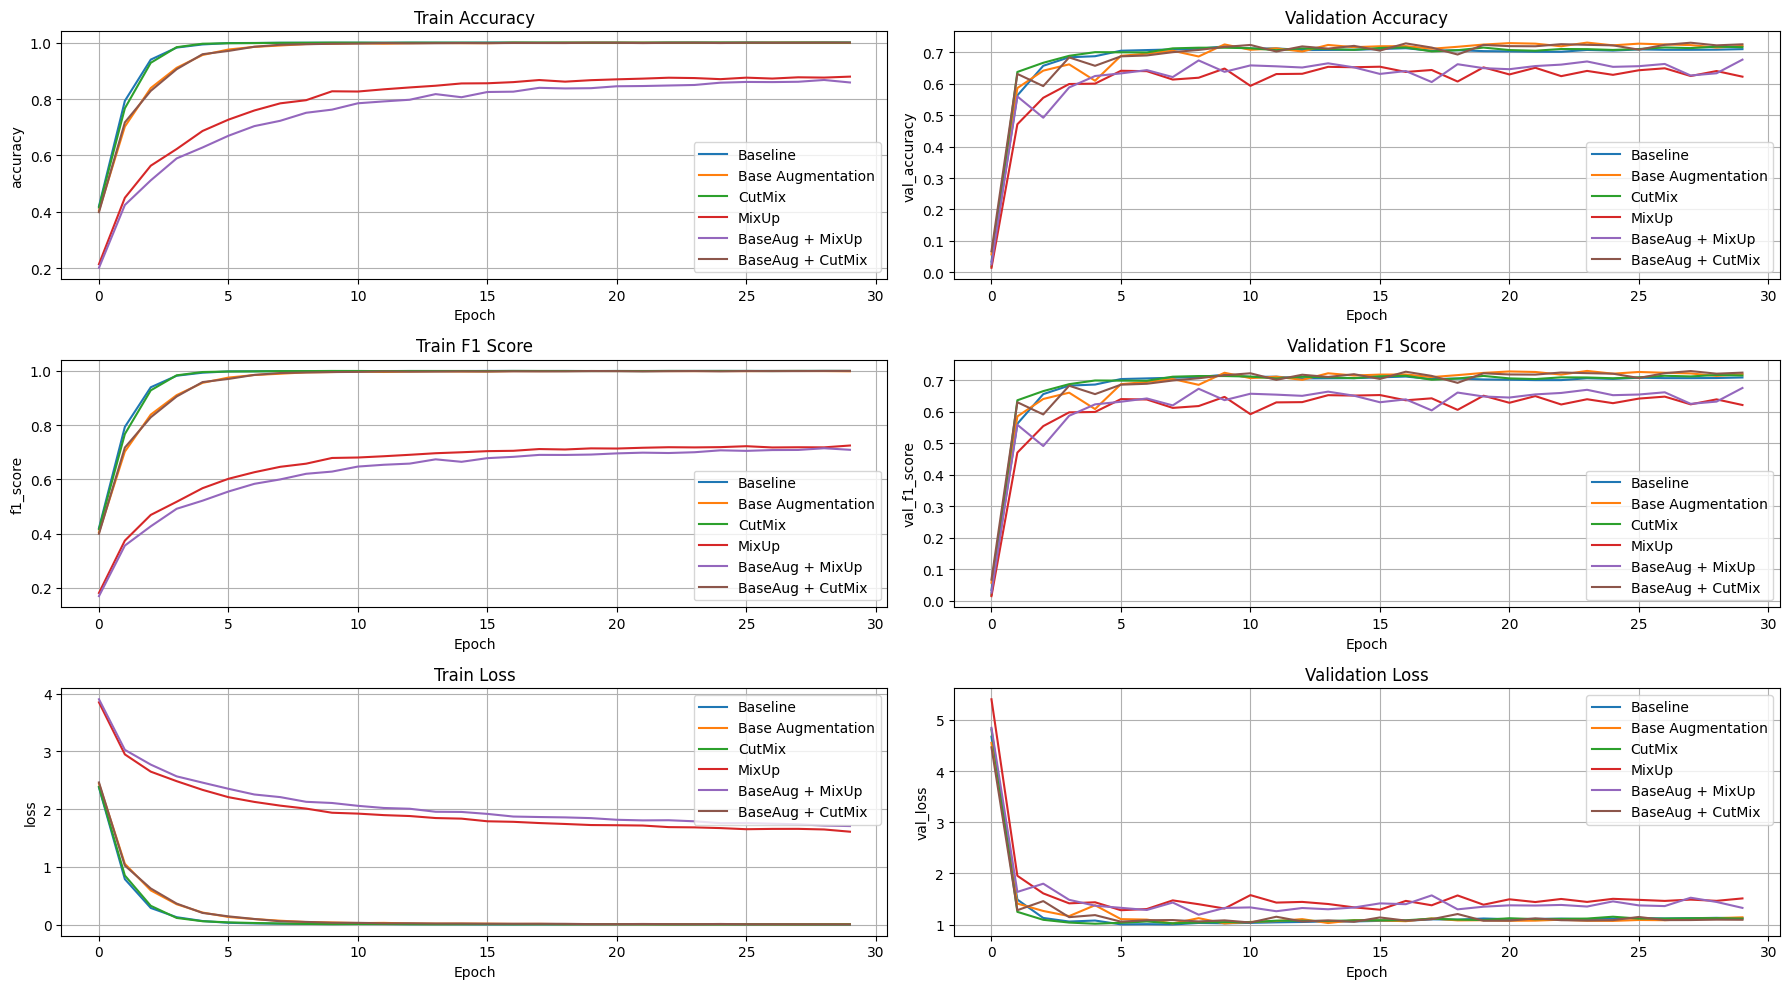

In [ ]:
plot_history(history_list, modelname_list)

train result to table

In [ ]:
df_best_summary = summarize_bestmodel_metrics(history_list, modelname_list)
display(df_best_summary)

,Model,Best Epoch (Val Loss),Val Accuracy,Val F1 Score,Val Loss
0,Baseline,8,0.7088,0.7087,1.0010
1,Base Augmentation,10,0.7246,0.7246,1.0210
2,CutMix,5,0.7000,0.7000,1.0155
3,MixUp,6,0.6408,0.6408,1.2795
4,BaseAug + MixUp,9,0.6737,0.6737,1.1922
5,BaseAug + CutMix,11,0.7229,0.7229,1.0387


# Inference

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score, classification_report
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

def inference_test_dataset(model_list, modelname_list, ds_test, batch_size=16, output_dir="./inference_results"):
    os.makedirs(output_dir, exist_ok=True)
    ds_test_proc = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=batch_size)
    results = []

    for model, name in zip(model_list, modelname_list):\
        # 추론 진행
        y_true, y_pred = [], []
        for x, y in tqdm(ds_test_proc, desc=f"Inference: {name}"):
            pred = model.predict(x, verbose=0)
            y_true_batch = np.argmax(y.numpy(), axis=1) if y.shape.rank > 1 else y.numpy()
            y_pred_batch = np.argmax(pred, axis=1)
            y_true.extend(y_true_batch)
            y_pred.extend(y_pred_batch)

        # 추론 결과 저장
        df = pd.DataFrame({
            "True Label": y_true,
            "Predicted Label": y_pred
        })
        csv_path = os.path.join(output_dir, f"{name}_results.csv")
        df.to_csv(csv_path, index=False)

        results.append((name, np.array(y_true), np.array(y_pred)))

    return results

def load_inference_results(modelname_list, output_dir="./inference_results"):
    results = []

    for name in modelname_list:
        csv_path = os.path.join(output_dir, f"{name}_results.csv")
        if not os.path.exists(csv_path):
            print(f"⚠️ Missing: {csv_path}")
            continue

        df = pd.read_csv(csv_path)
        y_true = df["True Label"].to_numpy()
        y_pred = df["Predicted Label"].to_numpy()

        results.append((name, y_true, y_pred))
        print(f"✅ Loaded: {csv_path}")

    return results

def load_best_models(modelname_list, model_dir="./", input_shape=(224, 224, 3), num_classes=120):
    models = []

    for name in modelname_list:
        model = build_resnet50_model(name, input_shape=input_shape, num_classes=num_classes)
        weights_path = os.path.join(model_dir, f"{name}_best.weights.h5")
        if os.path.exists(weights_path):
            # 모델 로드
            model.load_weights(weights_path)
            print(f"✅ Weights loaded: {weights_path}")

            # 컴파일
            model.compile(
                loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                metrics=[
                    "accuracy",
                    tf.keras.metrics.F1Score(average="micro", name="f1_score")
                ]
            )
            models.append(model)
        else:
            print(f"⚠️ Missing weights: {weights_path}")

    return models


추론 후 저장 실행 코드

In [ ]:
results = inference_test_dataset(model_list=best_models, modelname_list=modelname_list, ds_test=ds_test)

Inference: BaseAug + CutMix: 100%|██████████| 537/537 [00:47<00:00, 11.39it/s]


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/AIFFEL/DeepDive'
name_list=[
    "Baseline",
    "Base Augmentation",
    "CutMix",
    "MixUp",
    "BaseAug + MixUp",
    "BaseAug + CutMix",
]
modelname_list = [
    "base_resnet50",
    "base_aug_resnet50",
    "cutmix_aug_resnet50",
    "mixup_aug_resnet50",
    "baseaug_mixup_resnet50",
    "baseaug_cutmix_resnet50",
]
best_models = load_best_models(modelname_list, model_dir="./")
results = load_inference_results(name_list, output_dir="./inference_results")

/content/drive/MyDrive/Colab Notebooks/AIFFEL/DeepDive
✅ Weights loaded: ./base_resnet50_best.weights.h5
✅ Weights loaded: ./base_aug_resnet50_best.weights.h5
✅ Weights loaded: ./cutmix_aug_resnet50_best.weights.h5
✅ Weights loaded: ./mixup_aug_resnet50_best.weights.h5
✅ Weights loaded: ./baseaug_mixup_resnet50_best.weights.h5
✅ Weights loaded: ./baseaug_cutmix_resnet50_best.weights.h5
✅ Loaded: ./inference_results/Baseline_results.csv
✅ Loaded: ./inference_results/Base Augmentation_results.csv
✅ Loaded: ./inference_results/CutMix_results.csv
✅ Loaded: ./inference_results/MixUp_results.csv
✅ Loaded: ./inference_results/BaseAug + MixUp_results.csv
✅ Loaded: ./inference_results/BaseAug + CutMix_results.csv


인퍼런스 메트릭 확인

In [ ]:
def summarize_test_metric(modelname_list, model_objs, ds_test, num_classes=120, batch_size=16):
    summary = []
    ds_test_proc = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=batch_size)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for name, model in zip(modelname_list, model_objs):
        y_true_onehot, y_prob = [], []

        for x_batch, y_batch in tqdm(ds_test_proc, desc=f"Inference: {name}"):
            preds = model.predict(x_batch, verbose=0)
            y_prob.append(preds)
            y_true_onehot.append(y_batch.numpy())

        y_prob = np.concatenate(y_prob, axis=0)
        y_true_onehot = np.concatenate(y_true_onehot, axis=0)

        # 정답 인덱스
        y_true_idx = np.argmax(y_true_onehot, axis=1)
        y_pred_idx = np.argmax(y_prob, axis=1)

        # 수동 계산: loss, acc, f1
        loss = loss_fn(y_true_onehot, y_prob).numpy()
        acc = accuracy_score(y_true_idx, y_pred_idx)
        f1 = f1_score(y_true_idx, y_pred_idx, average='micro')

        # Top-k Error
        top1_err = 1 - tf.keras.metrics.top_k_categorical_accuracy(y_true_onehot, y_prob, k=1).numpy().mean()
        top5_err = 1 - tf.keras.metrics.top_k_categorical_accuracy(y_true_onehot, y_prob, k=5).numpy().mean()

        # AUC (macro)
        try:
            auc_macro = roc_auc_score(y_true_onehot, y_prob, average='macro', multi_class='ovr')
            auc_macro_str = f"{auc_macro:.4f}"
        except ValueError:
            auc_macro_str = "N/A"

        summary.append({
            "Model": name,
            "Test Accuracy": f"{acc:.4f}",
            "Test Loss": f"{loss:.4f}",
            "Test F1 (Micro)": f"{f1:.4f}",
            "Top-1 Error": f"{top1_err:.4f}",
            "Top-5 Error": f"{top5_err:.4f}",
            "AUC (Macro)": auc_macro_str
        })

    return pd.DataFrame(summary)

In [ ]:
summary=summarize_test_metric(modelname_list,best_models , ds_test)

Inference: baseaug_cutmix_resnet50: 100%|██████████| 537/537 [01:03<00:00,  8.52it/s]


In [ ]:
summary

,Model,Test Accuracy,Test Loss,Test F1 (Micro),Top-1 Error,Top-5 Error,AUC (Macro)
0,base_resnet50,0.7331,0.9739,0.7331,0.2669,0.0556,0.9940
1,base_aug_resnet50,0.7316,1.0106,0.7316,0.2684,0.0570,0.9939
2,cutmix_aug_resnet50,0.7233,0.9700,0.7233,0.2767,0.0555,0.9940
3,mixup_aug_resnet50,0.6690,1.2144,0.6690,0.3310,0.0800,0.9911
4,baseaug_mixup_resnet50,0.7366,1.0110,0.7366,0.2634,0.0566,0.9937
5,baseaug_cutmix_resnet50,0.7251,1.0383,0.7251,0.2749,0.0584,0.9934


# Analysis
---
#### 학습 시 Validation 결과


| Model                 | Val Acc    | Val F1     | Val Loss   |
| --------------------- | ---------- | ---------- | ---------- |
| **Base Augmentation** | **0.7246** | **0.7246** | 1.0210     |
| BaseAug + CutMix      | 0.7229     | 0.7229     | 1.0387     |
| **Baseline**          | 0.7088     | 0.7087     | **1.0010** |
| CutMix                | 0.7000     | 0.7000     | 1.0155     |
| BaseAug + MixUp       | 0.6737     | 0.6737     | 1.1922     |
| MixUp                 | 0.6408     | 0.6408     | 1.2795     |

Validation Accuracy / F1 기준:
- Base Augmentation이 가장 우수한 성능을 보이며, Baseline 대비 약 1.6% 향상됨
- CutMix나 MixUp 단독보다 BaseAug + CutMix 조합이 효과적이었음.

---
#### Train 결과

| **비교 항목**            | **Baseline** | **Base Aug** | **CutMix** | **MixUp**  | **BaseAug + MixUp** | **BaseAug + CutMix** | **비고**                      |
| -------------------- | ------------ | ------------ | ---------- | ---------- | ------------------- | -------------------- | --------------------------- |
| **Test Accuracy**    | 0.7331       | 0.7316       | 0.7233     | 0.6690     | **0.7366**          | 0.7251               | ↑ 정확도는 BaseAug+MixUp이 가장 우수 |
| **Test Loss**        | 0.9739       | 1.0106       | 0.9700     | **1.2144** | 1.0110              | 1.0383               |  MixUp 단독은 Loss 높음         |
| **F1 Score (Micro)** | 0.7331       | 0.7316       | 0.7233     | 0.6690     | **0.7366**          | 0.7251               |  F1도 BaseAug+MixUp 우세      |
| **Top-1 Error**      | 0.2669       | 0.2684       | 0.2767     | **0.3310** | **0.2634**          | 0.2749               |  MixUp 단독 오류 큼             |
| **Top-5 Error**      | **0.0556**   | 0.0570       | 0.0555     | **0.0800** | 0.0566              | 0.0584               |  Baseline이 가장 낮음           |
| **AUC (Macro)**      | 0.9940       | 0.9939       | 0.9940     | **0.9911** | 0.9937              | 0.9934               |  MixUp 단독만 다소 낮음           |


- mixup_aug_resnet50 모델은 전반적으로 가장 낮은 Accuracy(0.6690)와 가장 높은 Loss(1.2144)를 기록하며, 단독 MixUp의 효과가 제한적임을 보여주었다. 이는 초기 학습 불안정성과 class 구분 경계 약화 등의 MixUp의 단점이 그대로 나타난 결과로 해석된다.

- 그러나 BaseAug와의 조합에서는 오히려 최상위 성능을 기록했기 때문에, MixUp은 단독보다는 추가적인 보조 증강 기법으로 사용하는 것이 바람직함을 확인할 수 있다.

# 회고

- 실험을 진행하며 더 똑똑하게 실험하는 방법의 중요성을 절실히 느꼈다. 단순히 다양한 조합을 시도하는 것에 그치지 않고, 실험의 목적과 자원 제약을 고려한 전략적 설계가 필요하다는 점을 다시금 깨달았다.
- 이번에는 Google Colab을 통해 비교적 원활히 진행할 수 있었지만, 항상 이러한 환경이 보장되는 것은 아니기에 계산 자원이 제한된 상황에서도 효율적인 실험 설계를 고민해야 한다.
- 예를 들어, 이미지 해상도를 줄이거나, epoch 수를 최소화해 빠르게 경향을 파악한 후, promising한 설정만 정식 실험으로 확장하는 방식이 바람직할 것이다.
-앞으로는 단순히 모델 성능만 보는 것이 아니라, 시간, 메모리, 데이터 사용 효율성까지 종합적으로 고려하는 실험 루틴을 익혀두자


